# HW 3 INF 552
### Name: Siddhant Nadkarni
### USC ID: 2596-6618-89

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import seaborn as sns
from scipy.io import arff
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import glob

from DataLoader.DataLoader import DataLoader
from natsort import natsorted

from functools import reduce
from operator import add

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

### Q 1 a

In [2]:
dataPath = 'Homework_3_Data/AReM/'
dataLoader = DataLoader(dataPath)

finalFiles = dataLoader.getFinalDataFrame()
trainDF, testDF, classTrain, classTest, classMulTrain, classMulTest = dataLoader.testTrainSplit()

print(dataLoader.activities)
print(trainDF.shape)
print(testDF.shape)

trainDF = trainDF.drop(columns = trainDF.columns[0])
testDF = testDF.drop(columns = trainDF.columns[0])


trainDF = trainDF.fillna(method = 'pad')
testDF = testDF.fillna(method = 'pad')

['Homework_3_Data/AReM/bending1', 'Homework_3_Data/AReM/bending2', 'Homework_3_Data/AReM/cycling', 'Homework_3_Data/AReM/lying', 'Homework_3_Data/AReM/sitting', 'Homework_3_Data/AReM/standing', 'Homework_3_Data/AReM/walking']
(33119, 7)
(9120, 7)


### Q 1 b

In [3]:

trainDF.head()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,42.00,0.71,21.25,0.43,30.00,0.00
1,41.50,0.50,20.25,1.48,31.25,1.09
2,41.50,0.50,14.25,1.92,33.00,0.00
3,40.75,0.83,15.75,0.43,33.00,0.00
4,40.00,0.71,20.00,2.74,32.75,0.43


In [4]:
testDF.head()

,time,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,0.43,22.75,0.43,33.75,1.3
1,250,0.43,23.00,0.00,33.00,0.0
2,500,0.43,23.25,0.43,33.00,0.0
3,750,0.50,23.00,0.71,33.00,0.0
4,1000,0.50,24.00,0.00,33.00,0.0


### Q 1 c i) time-domain features usually used in time series classification are Means, Std Deviation, Skewness, Kurtosis for each dimensions, Maximum and Minimums, Cross correlations between dimensions and Auto correlations.

In [5]:
trainMod = trainDF.drop(columns = [trainDF.columns[3], trainDF.columns[4], trainDF.columns[5]])

In [6]:
trainMod.head()

,avg_rss12,var_rss12,avg_rss13
0,42.00,0.71,21.25
1,41.50,0.50,20.25
2,41.50,0.50,14.25
3,40.75,0.83,15.75
4,40.00,0.71,20.00


In [7]:
finalFiles = finalFiles.drop(columns = finalFiles.columns[0])
finalFiles.head()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,39.25,0.43,22.75,0.43,33.75,1.3
1,39.25,0.43,23.00,0.00,33.00,0.0
2,39.25,0.43,23.25,0.43,33.00,0.0
3,39.50,0.50,23.00,0.71,33.00,0.0
4,39.50,0.50,24.00,0.00,33.00,0.0


In [8]:
def extractTimeDomainFeatures(finalFiles):
    featureFrame = []
    for i in range(6):
        featureFrame.append(['min' + str(i), 'max' + str(i), 'mean' + str(i), 'median' + str(i),
                                                    'standard deviation' + str(i), '1st quartile' + str(i), '3rd quartile' + str(i)])
    featureFrame = reduce(add ,featureFrame)
    Finalfeaturelist = []
    count = 0
    for x in range(88):
        SectionFrame = finalFiles[x*480:(x+1)*480]
        featurelist = []
        for j in range(len(SectionFrame.columns)):
            featurelist.append(SectionFrame[SectionFrame.columns[j]].min())
            featurelist.append(SectionFrame[SectionFrame.columns[j]].max())
            featurelist.append(SectionFrame[SectionFrame.columns[j]].mean())
            featurelist.append(SectionFrame[SectionFrame.columns[j]].median())
            featurelist.append(SectionFrame[SectionFrame.columns[j]].std())
            featurelist.append(SectionFrame[SectionFrame.columns[j]].quantile(q = 0.25))
            featurelist.append(SectionFrame[SectionFrame.columns[j]].quantile(q = 0.75))
        Finalfeaturelist.append(featurelist)
        featureFrame.append(featurelist)
    FinalfeatureFrame = pd.DataFrame(Finalfeaturelist)
    for i in range(42):
        FinalfeatureFrame = FinalfeatureFrame.rename(columns = { i : featureFrame[i]})
    return FinalfeatureFrame

def getStandardDev(dataFrame, domainFeature):
    std = dataFrame[domainFeature].std()
    print("standard deviation of {} time-domain feature is: {}".format(domainFeature, std))

In [9]:
def extractTimeDomainFeaturesMod(trainFiles, classTrain):
    featureFrame = []
    for i in range(6):
        featureFrame.append(['min' + str(i), 'mean' + str(i), 'median' + str(i)])
    featureFrame.append(['class'])
    featureFrame = reduce(add ,featureFrame)
    Finalfeaturelist = []
    count = 0
    for x in range(69):
        SectionFrame = trainFiles[x*480:(x+1)*480]
        featurelist = []
        for j in range(len(SectionFrame.columns)):
            featurelist.append(SectionFrame[SectionFrame.columns[j]].min())
            featurelist.append(SectionFrame[SectionFrame.columns[j]].mean())
            featurelist.append(SectionFrame[SectionFrame.columns[j]].median())
        featurelist.append(classTrain[x])  
        Finalfeaturelist.append(featurelist)
        featureFrame.append(featurelist)
    FinalfeatureFrame = pd.DataFrame(Finalfeaturelist)
    for i in range(10):
        FinalfeatureFrame = FinalfeatureFrame.rename(columns = { i : featureFrame[i]})
    return FinalfeatureFrame

In [10]:
def getSectionFrame(featurelist, SectionFrame):
    for j in range(len(SectionFrame.columns)):
        featurelist.append(SectionFrame[SectionFrame.columns[j]].min())
        featurelist.append(SectionFrame[SectionFrame.columns[j]].mean())
        featurelist.append(SectionFrame[SectionFrame.columns[j]].median())
    return featurelist

def extractTimeDomainFeaturesMod2(trainFiles, classTrain):
    featureFrame = []
    for i in range(6):
        featureFrame.append(['min' + str(i), 'mean' + str(i), 'median' + str(i)])
    featureFrame.append(['class'])
    featureFrame = reduce(add ,featureFrame)
    Finalfeaturelist = []
    count = 0
    for x in range(67):
        SectionFrame1 = trainFiles[x*240:(x+1)*240]
        SectionFrame2 = trainFiles[(x+2)*240:(x+3)*240]
        featurelist = []
        featurelist = getSectionFrame(featurelist, SectionFrame1)
        featurelist = getSectionFrame(featurelist, SectionFrame2)
        featurelist.append(classTrain[x])  
        Finalfeaturelist.append(featurelist)
        featureFrame.append(featurelist)
    FinalfeatureFrame = pd.DataFrame(Finalfeaturelist)
    for i in range(len(featureFrame)):
        FinalfeatureFrame = FinalfeatureFrame.rename(columns = { i : featureFrame[i]})
    return FinalfeatureFrame


def extractTimeDomainFeaturesMod3(trainFiles, classTrain, length):
    featureFrame = []
    parts = int(480/length)
    for i in range(trainFiles.shape[1]*length):
        featureFrame.append(['min' + str(i), 'mean' + str(i), 'median' + str(i)])
    featureFrame.append(['class'])
    featureFrame = reduce(add ,featureFrame)
    Finalfeaturelist = []
    count = 0
    for x in range(len(classTrain) - length):
        featurelist = []
        for s in range(length):
            SectionFrame = trainFiles[(x+s)*parts:(x+1+s)*parts]
            featurelist = getSectionFrame(featurelist, SectionFrame)
        featurelist.append(classTrain[x])  
        Finalfeaturelist.append(featurelist)
#         featureFrame.append(featurelist)
    FinalfeatureFrame = pd.DataFrame(Finalfeaturelist)
    for i in range(len(featureFrame)):
        FinalfeatureFrame = FinalfeatureFrame.rename(columns = { i : featureFrame[i]})
    return FinalfeatureFrame

### Q 1 c) ii)

In [11]:
modTrainFeatureFrame3 = extractTimeDomainFeaturesMod3(trainDF, classTrain, 1)
modTrainFeatureFrame3.head()

,min0,mean0,median0,min1,mean1,median1,min2,mean2,median2,min3,mean3,median3,min4,mean4,median4,min5,mean5,median5,class
0,35.00,43.954500,44.33,0.0,0.426250,0.47,6.50,22.122354,23.000,0.0,0.497312,0.43,29.00,35.588458,36.00,0.0,0.493292,0.43,1
1,33.00,42.179812,43.50,0.0,0.696042,0.50,8.50,22.183625,23.000,0.0,0.989917,0.83,20.00,33.493917,35.00,0.0,0.613521,0.50,1
2,33.00,41.678063,41.75,0.0,0.535979,0.50,3.00,19.006563,19.125,0.0,0.841875,0.50,23.67,29.857083,30.00,0.0,0.383292,0.43,1
3,37.00,43.454958,43.25,0.0,0.378083,0.47,5.75,15.793333,15.000,0.0,0.849354,0.50,8.00,23.034792,23.50,0.0,0.679646,0.50,1
4,36.25,43.969125,44.50,0.0,0.413125,0.47,1.50,15.868021,16.250,0.0,0.666354,0.47,11.33,22.103750,21.67,0.0,0.555312,0.49,1


In [12]:
modTrainFeatureFrame = extractTimeDomainFeaturesMod3(trainMod, classTrain, 1)
modTrainFeatureFrame.head()

,min0,mean0,median0,min1,mean1,median1,min2,mean2,median2,class
0,35.00,43.954500,44.33,0.0,0.426250,0.47,6.50,22.122354,23.000,1
1,33.00,42.179812,43.50,0.0,0.696042,0.50,8.50,22.183625,23.000,1
2,33.00,41.678063,41.75,0.0,0.535979,0.50,3.00,19.006563,19.125,1
3,37.00,43.454958,43.25,0.0,0.378083,0.47,5.75,15.793333,15.000,1
4,36.25,43.969125,44.50,0.0,0.413125,0.47,1.50,15.868021,16.250,1


In [13]:
modTrainFeatureFrame2 = extractTimeDomainFeaturesMod3(trainMod, classTrain, 2)
modTrainFeatureFrame2.head()

,min0,mean0,median0,min1,mean1,median1,min2,mean2,median2,min3,mean3,median3,min4,mean4,median4,min5,mean5,median5,class
0,36.50,44.057167,44.50,0.0,0.381042,0.470,14.25,23.096792,24.000,35.00,43.851833,43.50,0.0,0.471458,0.500,6.5,21.147917,20.625,1
1,35.00,43.851833,43.50,0.0,0.471458,0.500,6.50,21.147917,20.625,33.75,43.278875,45.00,0.0,0.673292,0.485,11.0,23.141250,23.750,1
2,33.75,43.278875,45.00,0.0,0.673292,0.485,11.00,23.141250,23.750,33.00,41.080750,42.00,0.0,0.718792,0.500,8.5,21.226000,22.000,1
3,33.00,41.080750,42.00,0.0,0.718792,0.500,8.50,21.226000,22.000,33.00,41.621208,42.33,0.0,0.623083,0.500,3.0,19.081458,19.500,1
4,33.00,41.621208,42.33,0.0,0.623083,0.500,3.00,19.081458,19.500,39.25,41.734917,41.50,0.0,0.448875,0.500,12.5,18.931667,19.000,1


In [14]:
FinalfeatureFrame = extractTimeDomainFeatures(finalFiles)
print(FinalfeatureFrame.shape)
FinalfeatureFrame.head()

/anaconda3/envs/EE599/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


(88, 42)


,min0,max0,mean0,median0,standard deviation0,1st quartile0,3rd quartile0,min1,max1,mean1,...,standard deviation4,1st quartile4,3rd quartile4,min5,max5,mean5,median5,standard deviation5,1st quartile5,3rd quartile5
0,37.25,45.00,40.624792,40.50,1.476967,39.25,42.00,0.0,1.30,0.358604,...,2.188449,33.0000,36.00,0.0,1.92,0.570583,0.43,0.582915,0.0,1.30
1,38.00,45.67,42.812812,42.50,1.435550,42.00,43.67,0.0,1.22,0.372437,...,1.995255,32.0000,34.50,0.0,3.11,0.571083,0.43,0.601010,0.0,1.30
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,0.426250,...,1.999604,35.3625,36.50,0.0,1.79,0.493292,0.43,0.513506,0.0,0.94
3,33.00,47.75,42.179812,43.50,3.670666,39.15,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.0,1.00
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.0,1.79,0.383292,0.43,0.389164,0.0,0.50


In [15]:
from sklearn import preprocessing

featureFrame = []
for i in range(6):
        featureFrame.append(['min' + str(i), 'max' + str(i), 'mean' + str(i), 'median' + str(i),
                                                    'standard deviation' + str(i), '1st quartile' + str(i), '3rd quartile' + str(i)])
featureFrame = reduce(add ,featureFrame)
x = FinalfeatureFrame.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
FinalfeatureFrame = pd.DataFrame(x_scaled)

for i in range(42):
        FinalfeatureFrame = FinalfeatureFrame.rename(columns = { i : featureFrame[i]})

### Q 1 c) iii) Std devs for each time - domain  features

In [16]:
for i, feature in enumerate(FinalfeatureFrame.columns):
    getStandardDev(FinalfeatureFrame, feature)

standard deviation of min0 time-domain feature is: 0.20033777423333982
standard deviation of max0 time-domain feature is: 0.16032825501132045
standard deviation of mean0 time-domain feature is: 0.22509055413030368
standard deviation of median0 time-domain feature is: 0.22683383925340617
standard deviation of standard deviation0 time-domain feature is: 0.23144860689553956
standard deviation of 1st quartile0 time-domain feature is: 0.24694423385852143
standard deviation of 3rd quartile0 time-domain feature is: 0.18297841871129575
standard deviation of min1 time-domain feature is: 0.0
standard deviation of max1 time-domain feature is: 0.3009908187127182
standard deviation of mean1 time-domain feature is: 0.3457840733138215
standard deviation of median1 time-domain feature is: 0.33184835512235705
standard deviation of standard deviation1 time-domain feature is: 0.34445344211268425
standard deviation of 1st quartile1 time-domain feature is: 0.3304646863890474
standard deviation of 3rd quart

### Q 1 c) iii) 90% Bootstrap CI 

In [17]:
def bootstrap_resampling(population, num_samples,  num_loops, alpha, feature_str):
    population_std = population.std()
    pop_results = []

    for _ in range(num_loops):
        samples = population.sample(num_samples)
        std_sample = samples.std()
        pop_results.append(std_sample)
    pop_results = sorted(pop_results)
    alpha = alpha
    p = ((1.0-alpha)/2.0) * 100
    lower = np.percentile(pop_results, p)
    p = 100 - p
    upper = np.percentile(pop_results, p)
    print("CI for time domain feature - {} with {} probability is lower: {} and upper: {}".format(feature_str, alpha*100, lower, upper))
    return (lower, upper)



In [18]:
std_ranges=[]
features = {}
for i in range(len(FinalfeatureFrame.columns)):
    percentile_tiny_sample_count = bootstrap_resampling(FinalfeatureFrame[FinalfeatureFrame.columns[i]], 87, 100, 0.95, FinalfeatureFrame.columns[i])
    std_ranges.append(percentile_tiny_sample_count[1] - percentile_tiny_sample_count[0])
    features[FinalfeatureFrame.columns[i]] = percentile_tiny_sample_count[1] - percentile_tiny_sample_count[0]



CI for time domain feature - min0 with 95.0 probability is lower: 0.19868447737774292 and upper: 0.20150663134344443
CI for time domain feature - max0 with 95.0 probability is lower: 0.14762208414527564 and upper: 0.16126780529397466
CI for time domain feature - mean0 with 95.0 probability is lower: 0.2202132947456899 and upper: 0.22640259461814533
CI for time domain feature - median0 with 95.0 probability is lower: 0.22201092929815597 and upper: 0.22815067043278775
CI for time domain feature - standard deviation0 with 95.0 probability is lower: 0.2230663401641419 and upper: 0.23275850699593562
CI for time domain feature - 1st quartile0 with 95.0 probability is lower: 0.2433830907394519 and upper: 0.2482306073375316
CI for time domain feature - 3rd quartile0 with 95.0 probability is lower: 0.17723427235215153 and upper: 0.18403200181996715
CI for time domain feature - min1 with 95.0 probability is lower: 0.0 and upper: 0.0
CI for time domain feature - max1 with 95.0 probability is lowe

In [19]:
sorted_d = sorted(features.items(), key=lambda x: x[1])
# sorted_d

### Q 1 c) iv) Selected min median mean as the three most important time-domain features 
### as they had the highest standard deviation and thus would be more meaningful

In [20]:

modTrainFeatureFrame.head()

,min0,mean0,median0,min1,mean1,median1,min2,mean2,median2,class
0,35.00,43.954500,44.33,0.0,0.426250,0.47,6.50,22.122354,23.000,1
1,33.00,42.179812,43.50,0.0,0.696042,0.50,8.50,22.183625,23.000,1
2,33.00,41.678063,41.75,0.0,0.535979,0.50,3.00,19.006563,19.125,1
3,37.00,43.454958,43.25,0.0,0.378083,0.47,5.75,15.793333,15.000,1
4,36.25,43.969125,44.50,0.0,0.413125,0.47,1.50,15.868021,16.250,1


In [21]:
modTrainFeatureFrame2 = modTrainFeatureFrame2.fillna(0)
modTrainFeatureFrameWOCLASS = modTrainFeatureFrame.drop(columns = 'class')
modTrainFeatureFrameWOCLASS2 = modTrainFeatureFrame2.drop(columns = 'class')
modTrainFeatureFrame2.head()

,min0,mean0,median0,min1,mean1,median1,min2,mean2,median2,min3,mean3,median3,min4,mean4,median4,min5,mean5,median5,class
0,36.50,44.057167,44.50,0.0,0.381042,0.470,14.25,23.096792,24.000,35.00,43.851833,43.50,0.0,0.471458,0.500,6.5,21.147917,20.625,1
1,35.00,43.851833,43.50,0.0,0.471458,0.500,6.50,21.147917,20.625,33.75,43.278875,45.00,0.0,0.673292,0.485,11.0,23.141250,23.750,1
2,33.75,43.278875,45.00,0.0,0.673292,0.485,11.00,23.141250,23.750,33.00,41.080750,42.00,0.0,0.718792,0.500,8.5,21.226000,22.000,1
3,33.00,41.080750,42.00,0.0,0.718792,0.500,8.50,21.226000,22.000,33.00,41.621208,42.33,0.0,0.623083,0.500,3.0,19.081458,19.500,1
4,33.00,41.621208,42.33,0.0,0.623083,0.500,3.00,19.081458,19.500,39.25,41.734917,41.50,0.0,0.448875,0.500,12.5,18.931667,19.000,1


In [22]:
def num_list_maker(i, n):
    list_nums = [i]*n
    return list_nums

def get_string(stringCol, n):
    list_nums = [stringCol]*n
    return list_nums

def getListToPlt(modTrainFeatureFrameWOCLASS, modTrainFeatureFrame):
    x_num_list = []
    y_col_list = []
    mx_ticks = []
    label = []
    for col in modTrainFeatureFrameWOCLASS.columns:
        for i in range(len(modTrainFeatureFrameWOCLASS.columns)):
            if col == modTrainFeatureFrameWOCLASS.columns[i]:
                x_num_list.append(num_list_maker(i, 
                                                 len(list(modTrainFeatureFrameWOCLASS[modTrainFeatureFrameWOCLASS.columns[i]]))))
                mx_ticks.append(get_string(modTrainFeatureFrameWOCLASS.columns[i], 
                                           len(list(modTrainFeatureFrameWOCLASS[modTrainFeatureFrameWOCLASS.columns[i]]))))
                y_col_list.append(list(modTrainFeatureFrameWOCLASS[modTrainFeatureFrameWOCLASS.columns[i]]))
                label.append(list(modTrainFeatureFrame[modTrainFeatureFrame.columns[-1]]))
    return (x_num_list, y_col_list, mx_ticks, label)
            

### Q 1 d) i) Scatter plots for bending (red) vs Non bending activities (blue) for timeseries 1,2,6

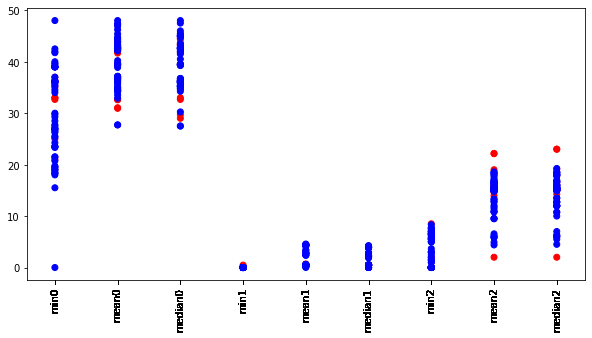

In [23]:
import matplotlib
plt.rcParams['figure.figsize'] = 10, 5

x_num_list, y_col_list, mx_ticks, label = getListToPlt(modTrainFeatureFrameWOCLASS, modTrainFeatureFrame)
mx_ticks = reduce(add, mx_ticks)
colors = ['blue', 'red']
x_num_list_mod = reduce(add, x_num_list)
plt.xticks(x_num_list_mod, mx_ticks, rotation = 'vertical')
plt.scatter(x_num_list, y_col_list, c=label, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

### Q 1 d) ii) Scatter plots for bending (red) vs Non bending activities (blue) for timeseries 1,2,6 each halved 
### into two more time series.

### There is considerable difference between this graph and the above graph. This one is more spread out

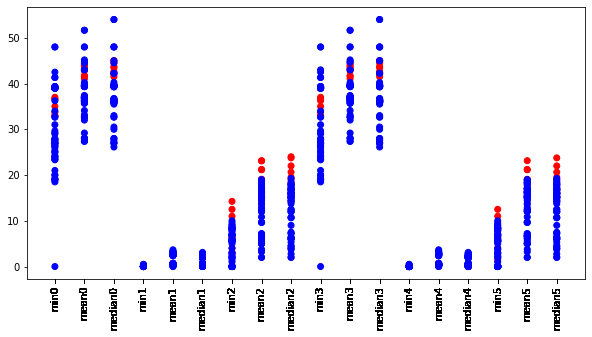

In [24]:
x_num_list, y_col_list, mx_ticks, label = getListToPlt(modTrainFeatureFrameWOCLASS2, modTrainFeatureFrame2)
mx_ticks = reduce(add, mx_ticks)
colors = ['blue', 'red']
x_num_list_mod = reduce(add, x_num_list)
plt.xticks(x_num_list_mod, mx_ticks, rotation = 'vertical')
plt.scatter(x_num_list, y_col_list, c=label, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

modTrainFeatureFrame3['class'].value_counts()

0    59
1     9
Name: class, dtype: int64

In [26]:
def getXandy(trainDataFrame):
    X = trainDataFrame.drop(columns = trainDataFrame.columns[-1])
    y = list(trainDataFrame[trainDataFrame.columns[-1]])
    return (X, y)



In [27]:
modTrainFeatureFrame3Test = extractTimeDomainFeaturesMod3(testDF, classTest, 1)
modTrainFeatureFrame3Test.head()

X_test, y_test = getXandy(modTrainFeatureFrame3)

In [28]:
X_train, y_train = getXandy(modTrainFeatureFrame3)

In [29]:
def getOptimumFeatures(trainDF, classTrain, l):
    model = LogisticRegression(solver='liblinear')
    selector = RFECV(estimator = model, step=1, cv=5, scoring='accuracy')
    modTrainFeatureFrame3 = extractTimeDomainFeaturesMod3(trainDF, classTrain, l)
    X, y = getXandy(modTrainFeatureFrame3)          
    X = selector.fit_transform(X,y)
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 0)
    model.fit(X_train,y_train)
    score = model.score(X_val,y_val)
    print("For L = {}, score = {} and parameters = {}".format(l,score, selector.n_features_))
    return model, selector

def newParamDF(OrigDF, selected_params):
    newDF = OrigDF[selected_params]
    newDF['class'] = OrigDF['class'].values
    return newDF

    
def getOptimumFeaturesTest(testDF, classTest, l, model):
    modTrainFeatureFrame3 = extractTimeDomainFeaturesMod3(testDF, classTest, l)
    X, y = getXandy(modTrainFeatureFrame3)          
    score = model.score(X_train,y_train)
    print("For L = {}, score = {} and parameters = {}".format(l,score, selector.n_features_))
    
    

### Q 1 d) iii) Break of up timeseries from l = 1 - 20

In [30]:


for l in range(1,21):
        getOptimumFeatures(trainDF, classTrain, l)

For L = 1, score = 1.0 and parameters = 8
For L = 2, score = 1.0 and parameters = 4
For L = 3, score = 1.0 and parameters = 1
For L = 4, score = 1.0 and parameters = 7
For L = 5, score = 1.0 and parameters = 4
For L = 6, score = 1.0 and parameters = 6
For L = 7, score = 1.0 and parameters = 10
For L = 8, score = 1.0 and parameters = 5
For L = 9, score = 1.0 and parameters = 2
For L = 10, score = 1.0 and parameters = 2
For L = 11, score = 1.0 and parameters = 4
For L = 12, score = 1.0 and parameters = 4
For L = 13, score = 1.0 and parameters = 3
For L = 14, score = 1.0 and parameters = 2
For L = 15, score = 1.0 and parameters = 63
For L = 16, score = 1.0 and parameters = 47
For L = 17, score = 1.0 and parameters = 61
For L = 18, score = 1.0 and parameters = 112
For L = 19, score = 0.8 and parameters = 1
For L = 20, score = 1.0 and parameters = 40


### Selected l = 1 since it gave a high score and would require less computations

In [31]:
model, selector = getOptimumFeatures(trainDF, classTrain, 1)
modTrainFeatureFrame3 = extractTimeDomainFeaturesMod3(trainDF, classTrain, 1)
X_train, y_train = getXandy(modTrainFeatureFrame3)
print("Model coefficients: {}".format(model.coef_))

For L = 1, score = 1.0 and parameters = 8
Model coefficients: [[-0.35725494 -0.57341664  0.47635908 -0.54909288 -0.51235233  1.28729812
  -0.46149716 -0.41739899]]


In [32]:
def getNewParams(modTrainFeatureFrame3, selector):
    selected_params = []
    all_params = list(modTrainFeatureFrame3.columns)
    for i in range(len(all_params) - 1):
        if selector.support_[i]:
            selected_params.append(all_params[i])
    return selected_params

In [33]:
selected_params = getNewParams(modTrainFeatureFrame3, selector)
newDF = newParamDF(modTrainFeatureFrame3, selected_params)
X_train_new, y_train_new = getXandy(newDF)
y_pred = model.predict(X_train_new)
confusion_matrix(y_train_new, y_pred)


lr_probs = model.predict_proba(X_train_new)
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_train_new))]
no_skill_probs = [0 for _ in range(len(y_train_new))]

/anaconda3/envs/EE599/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### below are the best parameters selected. Used RFE 5 Fold Cross validation to obtain them and used it in the right way to find best features first and then use them to cross - validate instead of doing cross validation first on all params/features

In [34]:
selected_params

['mean0',
 'mean1',
 'mean2',
 'median2',
 'median3',
 'mean4',
 'median4',
 'median5']

### Q 1 d) iv) Confusion Matrix, p-values, AUC, ROC

In [35]:
confusion_matrix(y_train_new, y_pred) #confusion matrix on new y_train for 
                                       #best params selected through K-Fold cross validation

array([[59,  0],
       [ 1,  8]])

### P values for entire training data

In [36]:
# p values

from sklearn.feature_selection import chi2

model = LogisticRegression(solver='liblinear')
selector = RFECV(estimator = model, step=1, cv=5, scoring='accuracy')
modTrainFeatureFrame3 = extractTimeDomainFeaturesMod3(trainDF, classTrain, 1)
X, y = getXandy(modTrainFeatureFrame3)          
X = selector.fit_transform(X,y)
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 0)
model.fit(X_train,y_train)

scores, pvalues = chi2(X_train, y_train)
print("For L = {}, score  = {} and parameters = {} for p values = {}".format(1,scores, selector.n_features_, pvalues))



For L = 1, score  = [ 0.36878649  7.21179845  0.66616315  0.62015094  4.5186335  37.21293629
 34.82040107  4.90542415] and parameters = 8 for p values = [5.43666481e-01 7.24258859e-03 4.14392515e-01 4.30991202e-01
 3.35276001e-02 1.05908876e-09 3.61564797e-09 2.67724758e-02]


In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [40]:
def getAUCcurve(y_train_new, lr_probs, ns_probs):
    ns_auc = roc_auc_score(y_train_new, ns_probs)
    lr_auc = roc_auc_score(y_train_new, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_train_new, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_train_new, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

# Code Looked up from (Citations): https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [41]:
def getROCCurve(y_train_new, lr_probs, no_skill_probs):    
    # calculate precision and recall for each threshold
    ns_precision, ns_recall, _ = precision_recall_curve(y_train_new, no_skill_probs)
    lr_precision, lr_recall, _ = precision_recall_curve(y_train_new, lr_probs)
    # calculate scores
    ns_f1, ns_auc = f1_score(y_train_new, no_skill_probs), auc(ns_recall, ns_precision)
    lr_f1, lr_auc = f1_score(y_train_new, y_pred), auc(lr_recall, lr_precision)
    # summarize scores
    print('No Skill: f1=%.3f auc=%.3f' % (ns_f1, ns_auc))
    print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    plt.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

# Code Looked up from (Citations): https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

### AUC confusion matrix on new traing set obtained for best params selected through K-Fold cross validation

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


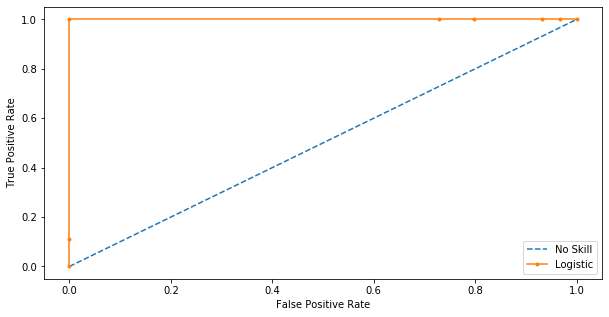

In [42]:
getAUCcurve(y_train_new, lr_probs, ns_probs)

### ROC confusion matrix on new traing set obtained for best params selected through K-Fold cross validation

No Skill: f1=0.000 auc=0.566
Logistic: f1=0.941 auc=1.000


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


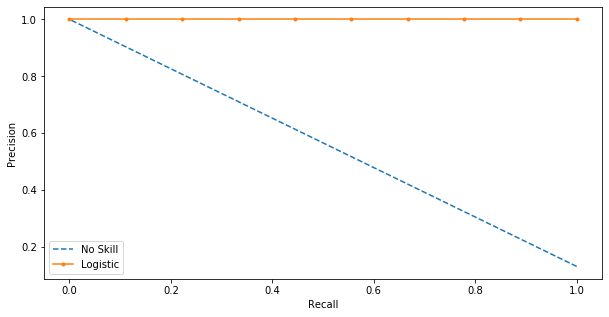

In [43]:
getROCCurve(y_train_new, lr_probs, no_skill_probs)

### Q 1) d) v) Logistic regression on test data

In [45]:
#logistic regression on l = 1
for l in range(1,19):
    model = LogisticRegression(solver='liblinear')
    selector = RFECV(estimator = model, step=1, cv=5, scoring='accuracy')
    modTrainFeatureFrame3 = extractTimeDomainFeaturesMod3(trainDF, classTrain, l)
    modTrainFeatureFrame3Test = extractTimeDomainFeaturesMod3(testDF, classTest, l)
    X, y = getXandy(modTrainFeatureFrame3)  
    X_test, y_test = getXandy(modTrainFeatureFrame3Test) 

    X = selector.fit_transform(X,y)
    X_test = selector.transform(X_test)
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 0)
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    print("For L = {}, score = {} and parameters = {} for test dataset".format(l,score, selector.n_features_))

For L = 1, score = 0.7777777777777778 and parameters = 8 for test dataset
For L = 2, score = 0.7647058823529411 and parameters = 4 for test dataset
For L = 3, score = 0.875 and parameters = 1 for test dataset
For L = 4, score = 0.7333333333333333 and parameters = 7 for test dataset
For L = 5, score = 0.7142857142857143 and parameters = 4 for test dataset
For L = 6, score = 0.6923076923076923 and parameters = 6 for test dataset
For L = 7, score = 0.6666666666666666 and parameters = 10 for test dataset
For L = 8, score = 0.6363636363636364 and parameters = 5 for test dataset
For L = 9, score = 0.7 and parameters = 2 for test dataset
For L = 10, score = 0.6666666666666666 and parameters = 2 for test dataset
For L = 11, score = 0.5 and parameters = 4 for test dataset
For L = 12, score = 0.42857142857142855 and parameters = 4 for test dataset
For L = 13, score = 0.3333333333333333 and parameters = 3 for test dataset
For L = 14, score = 0.2 and parameters = 2 for test dataset
For L = 15, sco

### Q 1 d) vii) Since there is imbalance of class, I umsampled lower class to be equal to majority through resampling

In [46]:
from sklearn.utils import resample
from scipy.sparse import coo_matrix

In [47]:
df_major = modTrainFeatureFrame3[modTrainFeatureFrame3['class'] == 0]
df_minor = modTrainFeatureFrame3[modTrainFeatureFrame3['class'] == 1]
df_minor_upsampled = resample(df_minor, replace=True, n_samples= 59 , random_state=123)

In [48]:
df_upsampled = pd.concat([df_major, df_minor_upsampled])

In [49]:
df_upsampled.head()

,min0,mean0,median0,min1,mean1,median1,min2,mean2,median2,min3,...,min105,mean105,median105,min106,mean106,median106,min107,mean107,median107,class
9,43.25,44.885769,45.000,0.0,0.390000,0.43,18.00,21.878077,22.250,0.0,...,0.0,0.889231,0.830,32.00,34.967692,35.665,0.0,0.603846,0.450,0
10,41.25,44.618846,45.000,0.0,0.435000,0.43,15.25,22.586538,22.375,0.0,...,0.0,0.640385,0.670,32.75,34.943077,35.250,0.0,0.568846,0.430,0
11,41.75,43.971154,44.500,0.0,0.328846,0.43,6.50,21.529231,24.000,0.0,...,0.0,0.881154,0.825,29.50,34.826923,36.000,0.0,0.500385,0.430,0
12,39.00,43.551154,43.625,0.0,0.478077,0.43,19.25,23.256154,23.750,0.0,...,0.0,1.642308,1.410,28.75,32.839615,31.710,0.0,0.544615,0.485,0
13,35.00,43.958077,45.000,0.0,0.556154,0.50,20.00,23.939231,24.000,0.0,...,0.0,0.850385,0.845,28.00,30.371154,30.000,0.0,0.381923,0.430,0


In [50]:
model = LogisticRegression(solver='liblinear')
selector = RFECV(estimator = model, step=1, cv=5, scoring='accuracy')

X_train, y_train = getXandy(df_upsampled)

X_train = selector.fit_transform(X_train,y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, random_state = 0)
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Confusion Matrix, AUC, ROC after resampling

In [51]:
selected_params = getNewParams(df_upsampled, selector)
newDF = newParamDF(df_upsampled, selected_params)
X_train_new, y_train_new = getXandy(newDF)
y_pred = model.predict(X_train_new)
print(confusion_matrix(y_train_new, y_pred))

lr_probs = model.predict_proba(X_train_new)
lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(y_train_new))]
no_skill_probs = [0 for _ in range(len(y_train_new))]

[[42  0]
 [ 0 59]]


/anaconda3/envs/EE599/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


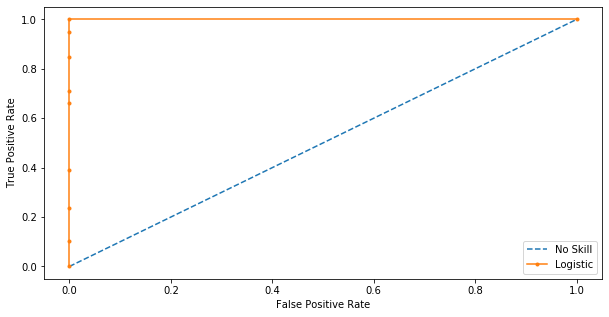

In [52]:
getAUCcurve(y_train_new, lr_probs, ns_probs)

No Skill: f1=0.000 auc=0.792
Logistic: f1=1.000 auc=1.000


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


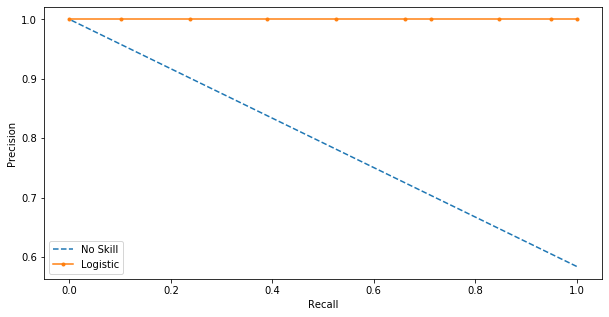

In [53]:
getROCCurve(y_train_new, lr_probs, no_skill_probs)

### Q 1 e) i) Binary Regression using L1 penalized Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegressionCV
c_values =[]
scores = []
l_val = {}
def regressionUsingL1(trainDF, classTrain, l):  
    modTrainFeatureFrame3 = extractTimeDomainFeaturesMod3(trainDF, classTrain, l)
    X, y = getXandy(modTrainFeatureFrame3)
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 0)
    clf = LogisticRegressionCV(cv=5, random_state=0, penalty = 'l1', solver= 'saga').fit(X_train, y_train)
    score = clf.score(X_val,y_val)
    scores.append(score)
    l_val[l] = score
    c_values.append(clf.C_)
    print("For L: {}  score is: {} and C value is: {} ".format(l, score, clf.C_))
    return model, scores

    

In [55]:
c_values =[]
scores = []
l_val = {}
for l in range(1,21):
    model, scores = regressionUsingL1(trainDF, classTrain, l)
        
best_l = max(l_val.keys(), key = (lambda l: l_val[l]))



/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 1  score is: 1.0 and C value is: [166.81005372] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 2  score is: 1.0 and C value is: [0.35938137] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 3  score is: 1.0 and C value is: [0.35938137] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 4  score is: 1.0 and C value is: [0.35938137] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 5  score is: 1.0 and C value is: [1291.54966501] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 6  score is: 1.0 and C value is: [1291.54966501] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 7  score is: 1.0 and C value is: [0.35938137] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 8  score is: 1.0 and C value is: [0.35938137] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 9  score is: 1.0 and C value is: [0.35938137] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 10  score is: 1.0 and C value is: [2.7825594] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 11  score is: 1.0 and C value is: [2.7825594] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 12  score is: 1.0 and C value is: [0.35938137] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 13  score is: 0.9166666666666666 and C value is: [10000.] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 14  score is: 1.0 and C value is: [2.7825594] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 15  score is: 1.0 and C value is: [21.5443469] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 16  score is: 1.0 and C value is: [1291.54966501] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 17  score is: 1.0 and C value is: [21.5443469] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 18  score is: 1.0 and C value is: [1291.54966501] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

For L: 19  score is: 1.0 and C value is: [166.81005372] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For L: 20  score is: 1.0 and C value is: [21.5443469] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [56]:
print("Best l* for L1 penalized  binary logistic regression is: {}".format(best_l))
print("Score for best l = l* is: {}".format(l_val[best_l]))

Best l* for L1 penalized  binary logistic regression is: 1
Score for best l = l* is: 1.0


### Q 1 f) i) Multi-class Regression using L1 penalized Logistic Regression

In [57]:
c_values =[]
scores = []
l_val = {}
for l in range(1,21):
        model, scores = regressionUsingL1(trainDF, classMulTrain, l)
best_l = max(l_val.keys(), key = (lambda l: l_val[l]))

/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 1  score is: 0.8571428571428571 and C value is: [3.59381366e-01 1.00000000e-04 1.00000000e+04 2.78255940e+00
 3.59381366e-01 1.00000000e-04 2.15443469e+01] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 2  score is: 0.14285714285714285 and C value is: [2.78255940e+00 1.00000000e-04 1.00000000e+04 1.00000000e-04
 1.00000000e-04 3.59381366e-01 1.00000000e-04] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 3  score is: 0.2857142857142857 and C value is: [3.59381366e-01 1.00000000e-04 2.78255940e+00 1.29154967e+03
 1.00000000e-04 3.59381366e-01 1.00000000e-04] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 4  score is: 0.38461538461538464 and C value is: [3.59381366e-01 1.00000000e-04 1.00000000e-04 1.00000000e-04
 1.00000000e+04 1.00000000e-04 1.00000000e-04] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For L: 5  score is: 0.5384615384615384 and C value is: [2.78255940e+00 2.78255940e+00 1.66810054e+02 3.59381366e-01
 2.78255940e+00 2.78255940e+00 1.00000000e-04] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For L: 6  score is: 0.6153846153846154 and C value is: [1.66810054e+02 2.78255940e+00 1.00000000e-04 1.00000000e-04
 3.59381366e-01 2.78255940e+00 1.66810054e+02] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 7  score is: 0.3076923076923077 and C value is: [1.00000000e-04 2.78255940e+00 1.00000000e+04 1.00000000e-04
 3.59381366e-01 2.15443469e+01 1.00000000e+04] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 8  score is: 0.3076923076923077 and C value is: [1.00000000e-04 2.15443469e+01 1.29154967e+03 2.15443469e+01
 3.59381366e-01 3.59381366e-01 1.00000000e-04] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 9  score is: 0.4166666666666667 and C value is: [1.00000000e-04 1.66810054e+02 1.29154967e+03 1.00000000e-04
 3.59381366e-01 3.59381366e-01 1.00000000e-04] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 10  score is: 0.6666666666666666 and C value is: [1.00000000e-04 1.66810054e+02 1.66810054e+02 1.66810054e+02
 1.00000000e-04 3.59381366e-01 1.66810054e+02] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 11  score is: 0.6666666666666666 and C value is: [1.00000000e-04 1.66810054e+02 2.78255940e+00 1.66810054e+02
 2.78255940e+00 2.78255940e+00 1.00000000e-04] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 12  score is: 0.5833333333333334 and C value is: [1.00000000e-04 1.00000000e+04 2.78255940e+00 1.66810054e+02
 1.00000000e-04 1.66810054e+02] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 13  score is: 0.9166666666666666 and C value is: [1.00000000e-04 1.00000000e-04 3.59381366e-01 1.66810054e+02
 2.15443469e+01 1.29154967e+03] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 14  score is: 0.7272727272727273 and C value is: [1.00000000e-04 1.66810054e+02 3.59381366e-01 1.00000000e+04
 1.29154967e+03 1.29154967e+03] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 15  score is: 0.5454545454545454 and C value is: [1.00000000e-04 1.00000000e-04 2.78255940e+00 1.29154967e+03
 2.78255940e+00 3.59381366e-01] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 16  score is: 0.7272727272727273 and C value is: [1.00000000e-04 1.29154967e+03 3.59381366e-01 1.66810054e+02
 2.78255940e+00 3.59381366e-01] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 17  score is: 0.9090909090909091 and C value is: [1.00000000e-04 1.00000000e+04 2.78255940e+00 1.66810054e+02
 2.78255940e+00 3.59381366e-01] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 18  score is: 0.6363636363636364 and C value is: [1.00000000e-04 1.00000000e-04 3.59381366e-01 1.66810054e+02
 1.00000000e+04 2.78255940e+00] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 19  score is: 0.8 and C value is: [1.00000000e-04 1.00000000e-04 3.59381366e-01 1.29154967e+03
 3.59381366e-01 2.78255940e+00] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/EE599/lib/pyt

For L: 20  score is: 0.8 and C value is: [1.29154967e+03 1.00000000e-04 3.59381366e-01 2.15443469e+01
 3.59381366e-01 2.78255940e+00] 


/anaconda3/envs/EE599/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [58]:
print("Best l* for l1  multiple logistic regression is: {}".format(best_l))
print("Score when l = l* is: {}".format(l_val[best_l]))

Best l* for l1  multiple logistic regression is: 13
Score when l = l* is: 0.9166666666666666


### Q 1 f) ii) Multi-class Regression using Gaussian and Multinomial Naive Bayes

In [59]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

c_values =[]
scores = []
l_val = {}

def gaussianNaiveBayes(trainDF, classTrain, l):  
    modTrainFeatureFrame3 = extractTimeDomainFeaturesMod3(trainDF, classTrain, l)
    X, y = getXandy(modTrainFeatureFrame3)
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 0)
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    score = clf.score(X_val,y_val)
    scores.append(score)
    l_val[l] = score
    print("For L: {}  score is: {} ".format(l, score))
    return model, scores


def gaussianNaiveBayesMultiNom(trainDF, classTrain, l):  
    modTrainFeatureFrame3 = extractTimeDomainFeaturesMod3(trainDF, classTrain, l)
    X, y = getXandy(modTrainFeatureFrame3)
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 0)
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    score = clf.score(X_val,y_val)
    scores.append(score)
    l_val[l] = score
    print("For L: {}  score is: {} ".format(l, score))
    return model, scores

In [60]:
c_values =[]
scores = []
l_val = {}
for l in range(1,21):
        model, scores = gaussianNaiveBayes(trainDF, classMulTrain, l)
best_l = max(l_val.keys(), key = (lambda l: l_val[l]))

For L: 1  score is: 0.7142857142857143 
For L: 2  score is: 0.7857142857142857 
For L: 3  score is: 0.5 
For L: 4  score is: 0.23076923076923078 
For L: 5  score is: 0.3076923076923077 
For L: 6  score is: 0.6153846153846154 
For L: 7  score is: 0.5384615384615384 
For L: 8  score is: 0.5384615384615384 
For L: 9  score is: 0.5 
For L: 10  score is: 0.5833333333333334 
For L: 11  score is: 0.4166666666666667 
For L: 12  score is: 0.75 
For L: 13  score is: 0.4166666666666667 
For L: 14  score is: 0.45454545454545453 
For L: 15  score is: 0.2727272727272727 
For L: 16  score is: 0.45454545454545453 
For L: 17  score is: 0.45454545454545453 
For L: 18  score is: 0.45454545454545453 
For L: 19  score is: 0.3 
For L: 20  score is: 0.5 


In [61]:
print("Best l* for gaussian Naive Bayes  multiple logistic regression is: {}".format(best_l))
print("Score when l = l* is: {}".format(l_val[best_l]))

Best l* for gaussian Naive Bayes  multiple logistic regression is: 2
Score when l = l* is: 0.7857142857142857


In [62]:
c_values =[]
scores = []
l_val = {}
for l in range(1,21):
        model, scores = gaussianNaiveBayesMultiNom(trainDF, classMulTrain, l)
best_l = max(l_val.keys(), key = (lambda l: l_val[l]))

For L: 1  score is: 0.7142857142857143 
For L: 2  score is: 0.35714285714285715 
For L: 3  score is: 0.42857142857142855 
For L: 4  score is: 0.5384615384615384 
For L: 5  score is: 0.5384615384615384 
For L: 6  score is: 0.8461538461538461 
For L: 7  score is: 0.6923076923076923 
For L: 8  score is: 0.6153846153846154 
For L: 9  score is: 0.5833333333333334 
For L: 10  score is: 0.6666666666666666 
For L: 11  score is: 0.8333333333333334 
For L: 12  score is: 0.6666666666666666 
For L: 13  score is: 0.75 
For L: 14  score is: 0.7272727272727273 
For L: 15  score is: 0.9090909090909091 
For L: 16  score is: 0.9090909090909091 
For L: 17  score is: 0.9090909090909091 
For L: 18  score is: 0.7272727272727273 
For L: 19  score is: 0.9 
For L: 20  score is: 0.7 


In [63]:
print("Best l* for Multinomial Naive Bayes  multiple logistic regression is: {}".format(best_l))
print("Score when l = l* is: {}".format(l_val[best_l]))

Best l* for Multinomial Naive Bayes  multiple logistic regression is: 15
Score when l = l* is: 0.9090909090909091


### Q 1 f) iii) ### As we can see above, the training dataset is imbalanced. Thus for imbalanced datasets, l1 logistic regression might be more appropriate than other methods. This is because l1 logistic regression has the ability to penalize heavily for wrongly classifying minority classes. This should result is less bias and more variance, which makes l1 logistic regression a better method